In [1]:
'''
GCBC with point maze (with multi-goal + color state space)
'''
from __future__ import print_function, division, unicode_literals
%load_ext autoreload
%autoreload 2
import math
import time
import os
import copy
import unicodedata
import string
import re
import random
import io
from io import open

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import distributions as pyd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode - o

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Custom weight init for Conv2D and Linear layers
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, "data"):
            m.bias.data.fill_(0.0)

# helper mlp init function
def mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

In [3]:
# MLP policy
class MLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, output_mod=None
    ):
        super().__init__()
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.outputs = dict()
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)

class MaskedMLPPolicy(nn.Module):
    def __init__(
        self, obs_dim, action_dim, hidden_dim, hidden_depth, default_x, output_mod=None
    ):
        super().__init__()
        self.mask = mlp(input_dim, hidden_dim, input_dim, hidden_depth, output_mod=nn.Sigmoid())
        self.trunk = mlp(input_dim, output_dim, hidden_dim, hidden_depth, output_mod)
        self.default_x = default_x
        self.apply(weight_init)

    def forward(self, x):
        mask = self.mask(x)
        mask = (mask>0.5).float() # convert to binary value
        masked_x = (mask*x + (torch.ones(mask.shape)-mask)*torch.Tensor(self.default_x)).float()
        return self.trunk(masked_x)
    
    def mask_loss(self, x):
        mask = self.mask(x)
        return mask.sum()

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

# MLP policy
class CNNPolicy(nn.Module):
    def __init__(
        self, goal_dim, action_dim, hidden_size, output_mod=None
    ):
        super().__init__()
        self.goal = mlp(goal_dim, hidden_size, hidden_dim=0, hidden_depth=0, output_mod=None)
        self.state = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1), nn.ReLU(inplace=True), Flatten(),
            nn.Linear(32, hidden_size), nn.ReLU(inplace=True)
            )
        self.trunk = mlp(hidden_size*2, action_dim, hidden_dim=100, hidden_depth=1)
        self.apply(weight_init)

    def forward(self, goal, x):
        goal = self.goal(goal)
        state = x.permute(0,3,1,2) # moves channels to pytorch format
        state = self.state(state)
        full_state = torch.cat((goal,state),dim=1)
        return self.trunk(full_state)

In [5]:
# Goal-conditioned Point Maze (with multi state + color)
import gym
import gym.wrappers

class PointEnvComplex(gym.Env):
    def __init__(self):
        self.pos = np.array([99., 99.])
        self.obj1_pos = np.array([99., 99.])
        self.obj1_color = np.array([99., 99., 99.])
        self.obj2_pos = np.array([99., 99.])
        self.obj2_color = np.array([99., 99., 99.])
        self.goal_pos = np.array([99., 99.])
        self.goal_color = np.array([99., 99., 99.])
        self.max_vel = 1.
        self.observation_space = gym.spaces.Box(
            -np.inf * np.ones(14), np.inf * np.ones(14)
        )
        self.action_space = gym.spaces.Box(-np.ones(2), np.ones(2))
        self.action_space.seed(0)
        self.observation_space.seed(0)

    # creates test env with defined goal locations + colors
    def reset(self, obj_angles=360, obj_colors=[0,1,2], discretize=10):
        self.pos = np.array([0., 0.])
        self.obj1_pos, self.obj1_color = self.gen_obj(obj_angles, obj_colors, discretize)
        self.obj2_pos, self.obj2_color = self.gen_obj(obj_angles, obj_colors, discretize)

        # choose goal from random in objects
        goal_obj = random.randint(1, 2)
        if goal_obj == 1:
            self.goal_pos = self.obj1_pos
            self.goal_color = self.obj1_color
        elif goal_obj == 2:
            self.goal_pos = self.obj2_pos
            self.goal_color = self.obj2_color
        return self.get_obs()

    def get_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_color]))
    
    def get_full_obs(self):
        return copy.deepcopy(np.concatenate([self.pos, self.obj1_pos, self.obj1_color, self.obj2_pos, self.obj2_color, self.goal_pos, self.goal_color]))

    def step(self, action: np.ndarray):
        self.pos += self.max_vel*action
        reward = -np.linalg.norm((self.pos - self.goal_pos))
        return self.get_full_obs(), reward, False, {}

    # function to generate object based on angles, colors, and discretization ranges
    def gen_obj(self, obj_angles, obj_colors, discretize):
        angle = np.random.uniform(0, obj_angles) # samples angle from range
        angle = round(angle/discretize)*discretize # discretizes to defined range (default 10)
        pos = np.array([5*np.cos(np.deg2rad(angle)), 5*np.sin(np.deg2rad(angle))]) # maps to unit circle
        
        color = np.zeros(shape = 3) # defines total number of colors to choose from
        rand_color = random.sample(obj_colors,1) # samples color from range
        color[rand_color] = 1.
        return pos, color

In [10]:
def get_color(color):
    if color[0] == 1.:
        return 'red'
    elif color[1] == 1.:
        return 'blue'
    elif color[2] == 1.:
        return 'green'
        
def plot_env(env):
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter([env.pos[0]],[env.pos[1]], marker='o', color='black', s=30) # plots agent
    plt.scatter([env.obj1_pos[0]],[env.obj1_pos[1]], marker='s', color=get_color(env.obj1_color), s=30) # plots obj1
    plt.scatter([env.obj2_pos[0]],[env.obj2_pos[1]], marker='s', color=get_color(env.obj2_color), s=30) # plots obj2
    plt.scatter([env.goal_pos[0]],[env.goal_pos[1]], marker='*', color=get_color(env.goal_color), s=100) # plots goal

def plot_full_state(state):
    fig = plt.figure(figsize=(.5, .5))
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    colors = sns.color_palette("hls", 10)
    
    plt.scatter(state[0], state[1], marker='o', color='black', s=.25) # plots agent
    plt.scatter(state[2], state[3], marker='s', color=get_color(state[4:7]), s=1) # plots obj1
    plt.scatter(state[7], state[8], marker='s', color=get_color(state[9:12]), s=1) # plots obj1
    plt.scatter(state[12], state[13], marker='*', color=get_color(state[14:17]), s=5) # plots goal
    plt.axis('off')
    with io.BytesIO() as buff:
        fig.savefig(buff, format='raw')
        buff.seek(0)
        data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    img = data.reshape((int(h), int(w), -1))
    img = img[:,:,:3]
    return img

[ 0.          0.         -3.83022222 -3.21393805  1.          0.
  0.          4.6984631  -1.71010072  0.          1.          0.
  0.          1.          0.        ]


(36, 36, 3)

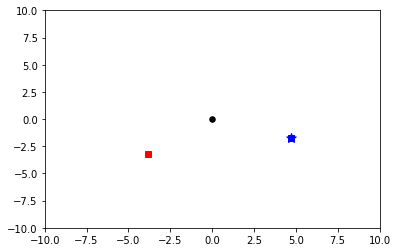

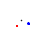

In [11]:
env = PointEnvComplex()
print(env.reset(obj_angles=360, obj_colors=[0,1], discretize=10))
plot_env(env)
img = plot_full_state(env.get_full_obs())
img.shape

In [12]:
# generates random trajs within specified constraints
def gen_trajs(env, num_trajs=1, obj_angles=360, obj_colors=[0,1,2], discretize=10):
    trajs = []
    for traj in range(num_trajs):
        env.reset(obj_angles, obj_colors, discretize)
        plot_env(env)
        # rolls out a trajectory towards the goal
        traj = {'obs': [],'acts': [], 'goal': []}
        delta_vector = env.goal_pos
        o = plot_full_state(env.get_full_obs())
        for i in range(20):
            act = delta_vector * 0.05 # Go in direction between start and end
            no, r, d, _ = env.step(act)
            traj['obs'].append(o.copy())
            traj['acts'].append(act.copy())
            traj['goal'].append(env.goal_color)
            o = plot_full_state(no.copy())
        traj['obs'] = np.array(traj['obs'])
        traj['acts'] = np.array(traj['acts'])
        traj['goal'] = np.array(traj['goal'])
        #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs + goals
        trajs.append(traj)
    return trajs

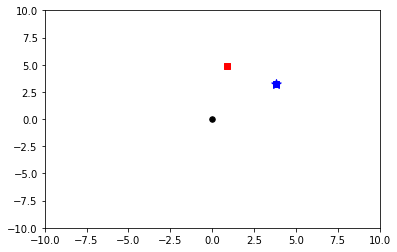

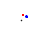

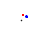

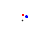

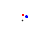

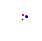

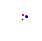

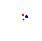

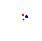

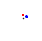

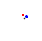

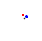

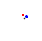

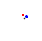

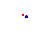

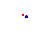

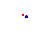

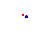

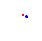

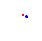

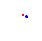

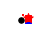

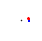

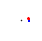

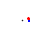

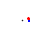

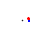

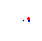

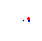

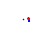

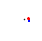

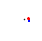

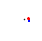

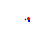

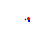

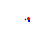

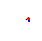

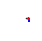

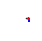

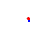

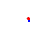

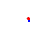

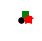

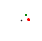

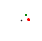

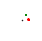

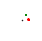

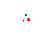

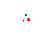

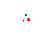

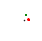

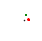

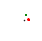

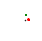

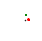

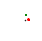

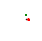

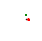

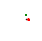

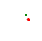

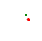

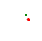

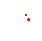

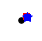

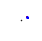

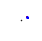

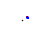

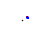

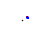

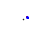

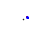

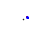

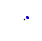

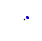

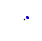

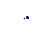

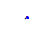

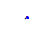

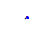

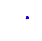

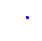

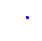

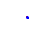

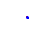

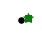

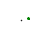

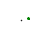

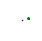

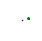

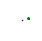

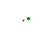

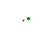

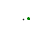

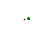

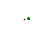

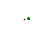

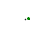

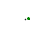

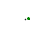

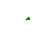

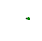

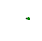

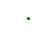

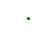

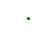

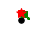

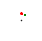

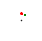

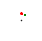

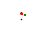

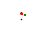

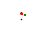

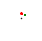

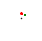

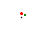

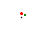

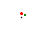

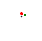

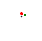

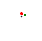

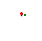

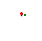

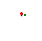

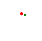

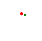

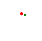

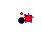

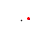

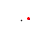

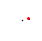

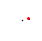

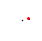

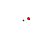

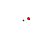

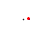

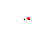

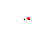

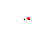

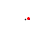

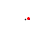

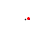

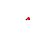

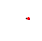

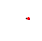

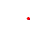

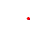

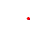

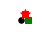

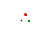

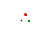

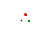

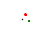

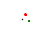

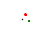

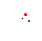

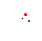

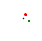

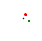

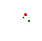

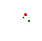

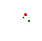

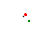

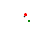

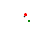

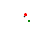

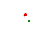

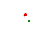

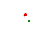

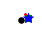

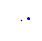

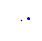

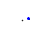

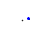

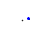

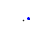

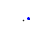

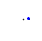

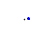

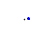

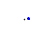

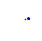

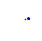

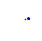

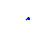

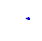

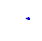

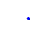

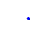

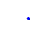

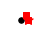

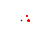

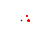

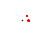

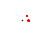

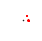

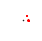

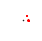

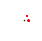

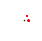

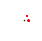

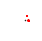

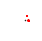

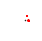

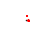

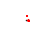

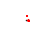

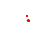

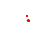

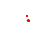

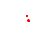

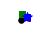

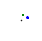

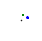

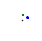

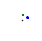

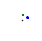

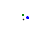

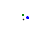

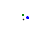

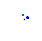

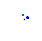

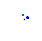

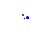

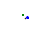

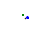

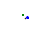

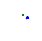

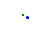

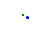

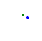

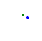

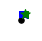

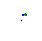

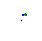

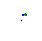

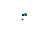

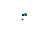

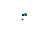

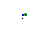

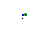

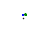

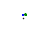

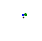

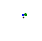

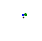

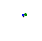

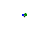

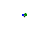

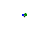

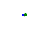

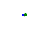

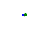

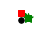

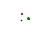

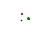

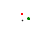

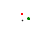

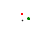

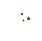

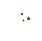

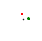

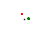

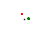

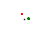

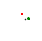

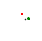

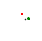

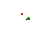

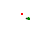

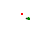

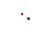

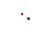

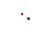

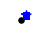

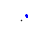

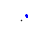

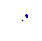

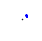

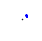

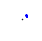

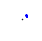

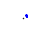

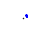

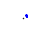

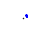

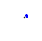

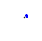

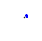

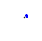

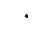

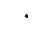

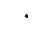

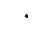

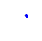

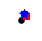

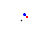

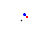

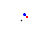

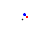

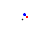

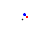

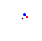

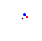

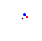

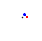

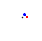

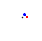

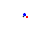

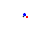

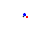

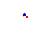

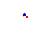

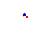

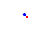

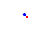

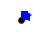

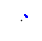

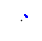

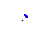

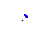

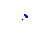

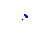

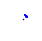

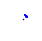

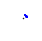

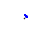

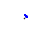

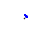

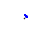

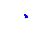

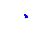

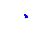

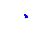

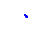

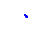

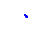

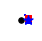

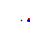

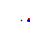

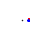

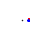

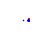

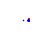

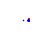

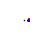

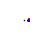

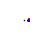

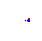

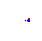

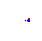

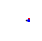

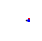

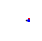

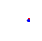

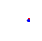

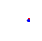

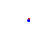

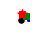

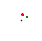

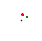

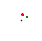

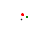

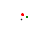

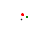

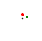

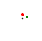

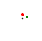

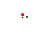

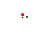

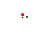

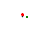

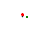

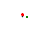

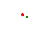

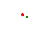

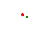

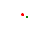

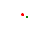

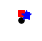

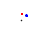

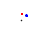

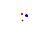

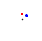

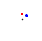

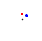

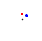

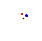

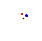

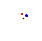

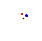

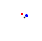

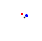

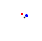

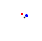

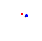

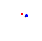

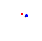

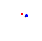

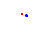

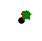

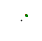

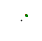

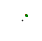

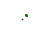

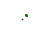

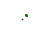

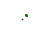

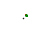

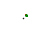

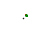

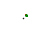

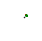

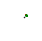

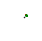

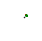

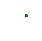

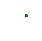

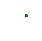

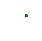

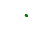

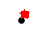

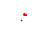

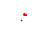

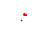

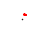

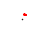

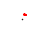

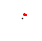

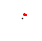

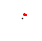

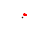

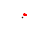

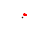

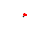

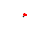

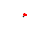

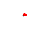

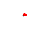

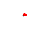

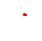

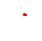

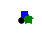

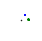

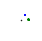

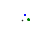

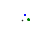

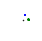

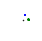

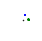

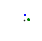

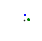

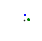

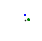

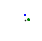

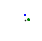

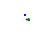

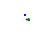

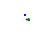

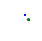

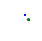

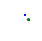

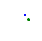

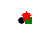

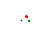

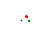

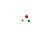

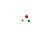

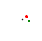

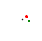

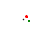

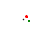

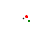

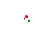

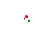

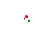

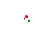

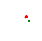

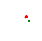

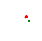

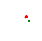

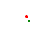

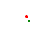

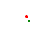

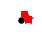

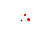

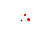

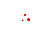

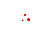

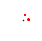

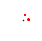

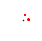

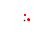

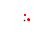

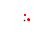

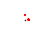

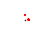

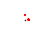

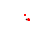

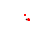

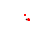

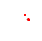

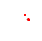

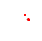

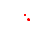

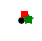

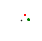

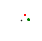

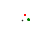

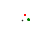

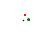

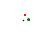

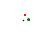

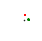

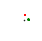

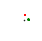

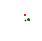

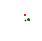

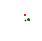

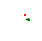

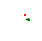

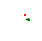

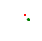

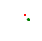

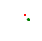

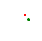

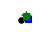

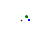

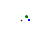

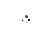

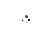

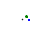

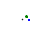

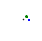

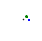

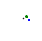

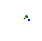

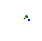

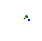

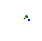

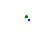

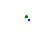

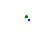

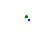

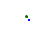

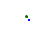

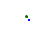

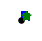

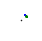

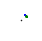

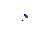

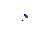

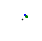

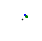

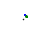

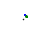

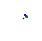

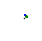

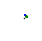

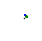

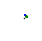

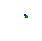

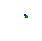

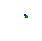

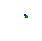

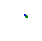

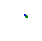

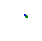

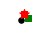

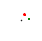

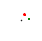

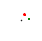

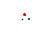

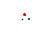

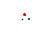

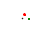

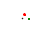

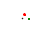

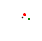

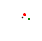

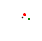

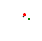

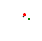

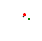

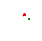

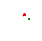

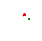

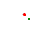

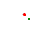

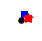

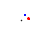

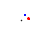

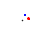

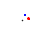

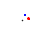

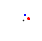

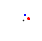

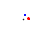

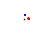

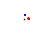

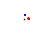

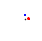

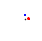

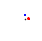

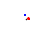

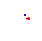

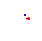

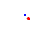

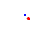

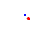

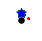

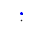

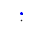

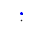

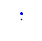

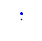

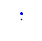

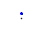

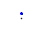

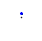

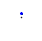

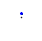

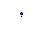

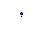

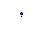

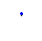

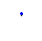

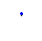

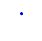

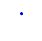

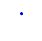

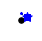

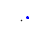

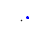

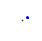

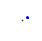

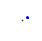

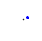

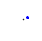

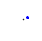

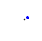

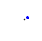

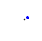

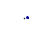

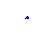

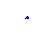

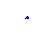

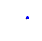

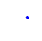

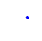

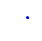

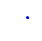

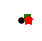

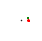

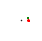

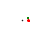

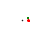

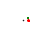

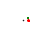

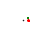

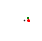

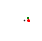

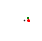

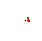

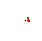

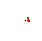

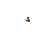

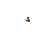

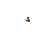

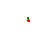

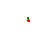

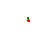

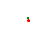

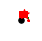

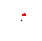

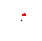

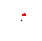

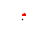

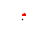

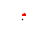

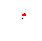

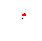

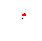

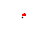

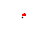

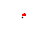

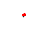

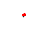

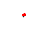

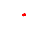

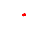

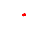

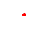

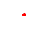

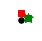

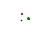

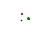

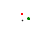

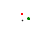

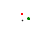

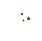

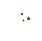

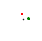

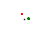

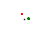

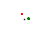

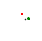

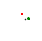

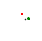

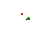

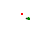

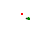

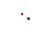

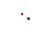

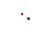

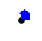

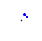

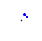

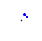

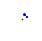

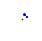

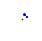

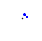

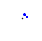

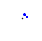

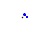

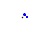

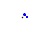

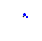

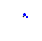

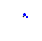

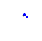

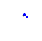

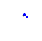

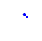

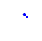

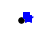

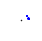

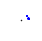

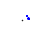

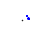

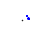

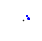

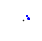

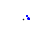

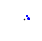

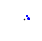

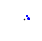

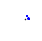

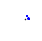

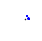

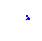

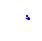

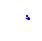

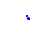

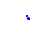

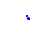

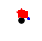

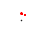

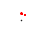

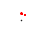

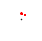

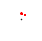

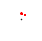

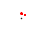

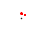

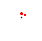

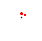

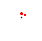

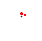

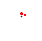

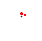

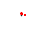

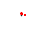

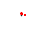

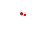

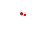

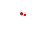

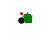

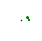

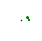

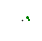

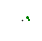

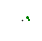

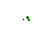

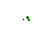

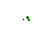

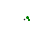

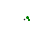

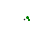

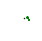

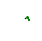

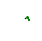

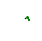

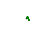

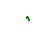

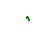

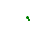

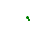

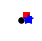

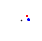

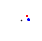

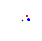

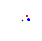

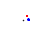

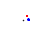

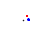

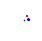

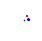

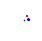

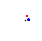

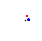

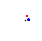

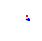

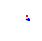

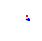

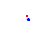

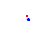

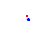

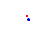

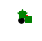

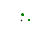

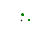

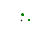

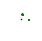

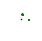

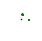

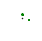

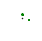

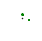

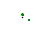

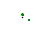

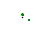

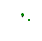

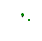

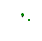

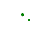

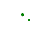

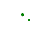

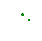

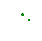

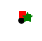

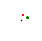

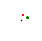

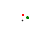

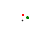

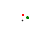

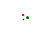

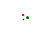

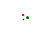

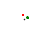

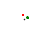

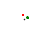

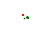

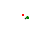

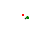

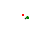

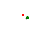

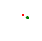

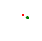

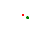

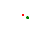

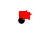

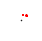

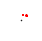

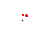

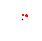

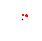

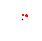

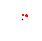

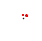

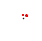

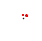

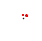

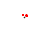

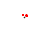

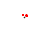

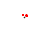

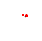

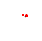

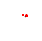

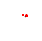

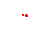

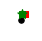

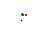

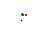

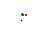

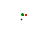

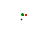

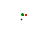

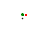

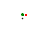

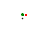

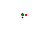

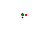

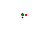

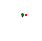

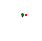

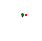

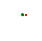

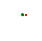

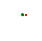

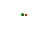

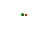

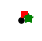

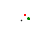

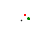

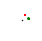

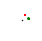

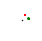

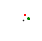

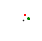

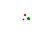

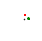

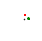

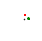

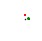

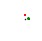

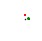

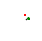

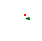

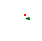

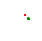

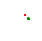

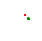

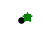

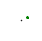

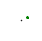

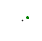

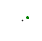

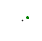

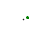

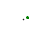

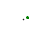

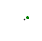

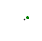

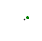

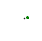

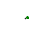

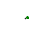

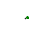

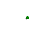

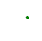

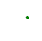

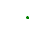

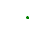

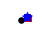

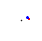

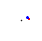

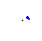

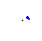

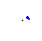

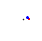

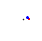

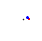

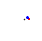

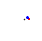

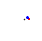

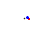

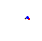

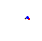

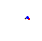

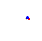

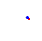

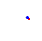

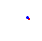

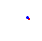

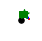

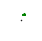

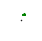

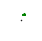

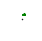

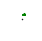

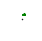

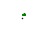

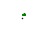

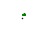

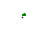

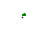

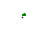

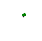

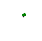

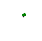

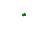

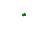

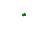

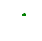

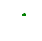

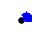

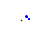

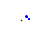

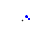

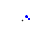

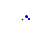

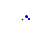

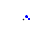

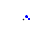

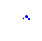

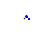

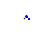

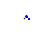

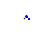

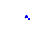

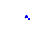

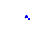

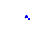

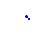

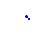

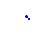

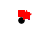

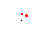

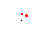

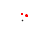

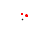

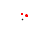

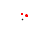

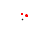

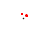

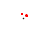

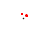

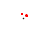

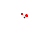

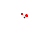

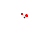

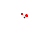

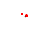

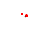

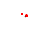

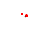

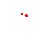

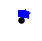

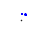

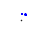

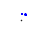

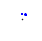

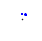

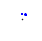

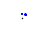

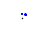

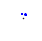

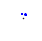

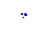

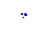

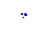

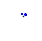

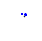

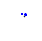

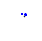

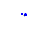

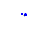

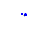

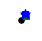

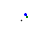

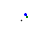

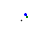

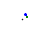

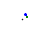

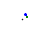

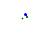

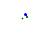

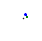

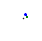

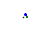

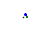

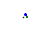

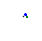

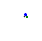

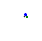

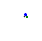

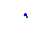

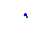

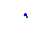

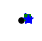

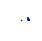

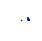

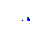

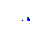

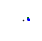

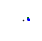

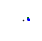

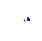

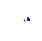

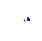

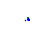

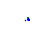

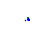

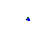

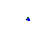

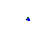

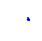

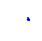

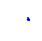

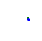

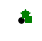

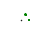

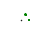

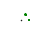

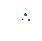

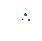

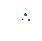

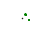

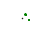

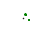

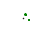

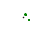

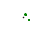

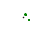

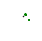

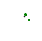

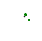

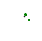

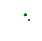

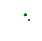

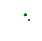

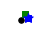

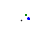

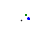

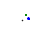

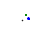

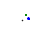

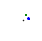

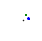

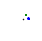

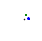

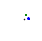

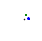

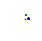

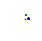

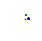

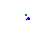

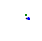

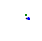

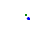

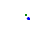

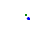

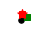

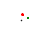

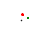

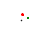

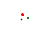

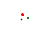

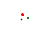

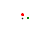

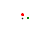

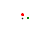

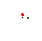

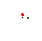

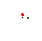

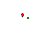

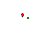

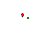

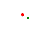

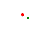

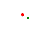

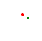

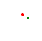

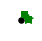

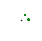

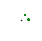

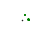

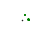

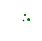

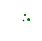

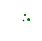

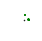

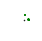

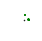

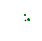

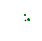

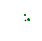

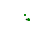

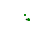

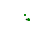

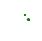

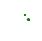

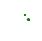

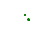

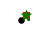

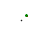

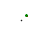

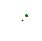

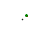

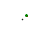

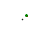

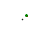

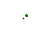

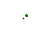

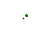

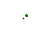

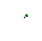

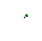

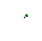

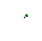

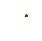

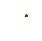

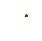

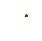

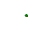

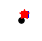

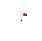

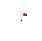

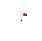

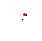

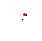

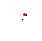

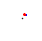

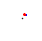

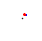

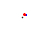

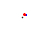

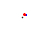

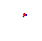

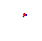

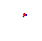

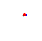

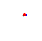

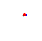

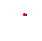

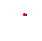

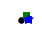

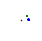

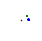

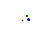

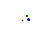

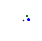

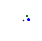

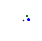

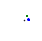

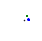

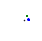

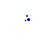

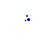

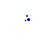

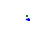

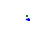

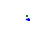

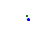

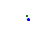

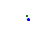

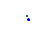

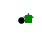

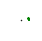

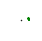

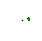

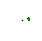

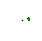

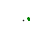

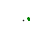

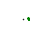

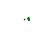

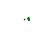

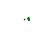

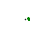

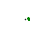

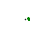

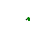

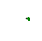

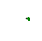

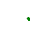

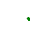

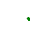

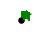

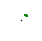

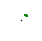

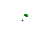

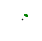

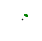

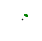

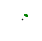

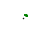

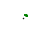

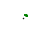

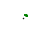

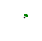

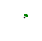

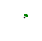

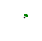

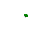

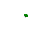

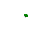

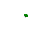

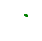

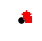

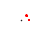

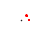

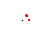

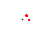

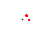

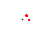

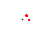

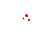

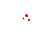

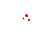

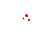

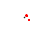

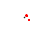

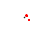

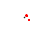

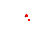

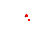

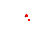

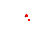

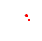

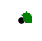

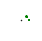

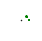

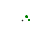

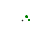

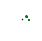

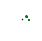

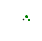

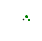

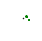

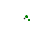

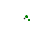

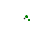

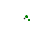

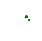

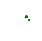

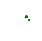

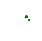

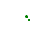

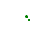

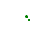

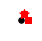

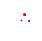

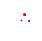

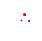

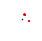

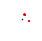

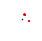

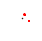

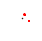

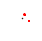

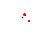

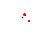

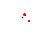

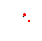

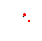

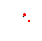

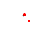

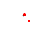

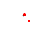

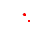

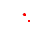

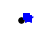

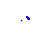

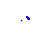

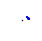

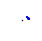

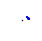

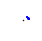

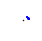

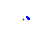

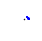

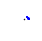

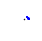

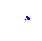

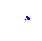

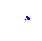

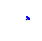

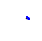

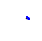

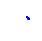

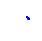

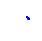

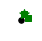

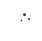

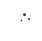

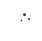

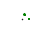

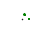

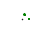

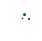

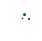

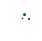

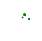

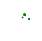

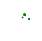

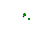

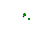

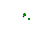

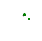

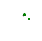

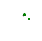

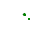

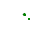

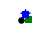

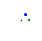

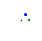

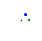

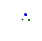

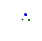

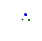

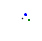

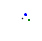

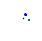

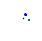

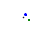

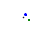

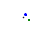

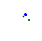

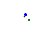

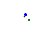

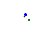

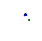

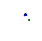

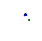

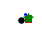

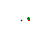

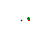

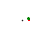

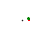

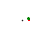

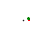

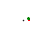

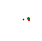

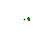

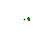

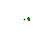

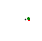

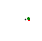

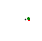

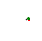

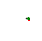

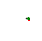

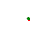

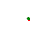

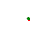

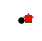

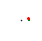

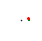

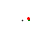

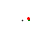

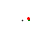

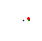

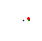

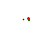

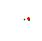

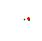

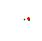

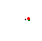

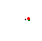

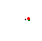

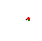

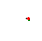

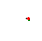

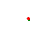

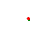

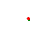

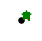

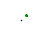

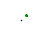

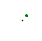

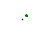

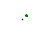

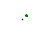

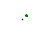

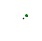

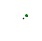

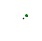

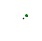

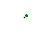

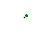

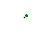

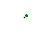

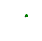

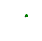

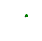

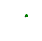

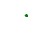

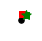

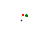

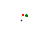

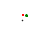

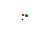

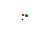

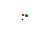

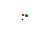

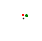

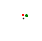

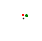

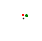

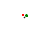

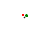

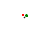

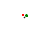

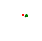

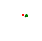

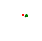

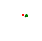

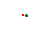

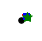

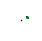

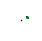

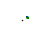

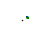

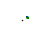

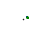

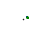

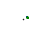

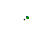

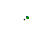

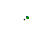

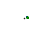

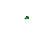

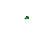

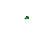

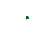

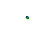

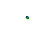

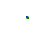

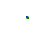

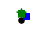

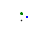

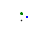

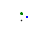

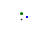

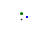

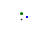

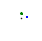

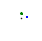

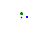

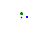

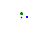

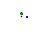

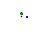

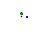

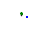

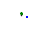

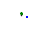

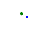

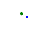

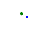

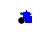

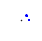

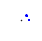

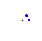

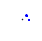

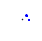

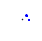

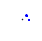

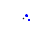

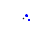

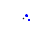

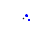

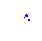

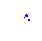

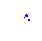

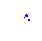

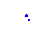

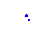

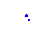

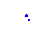

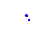

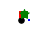

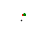

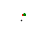

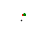

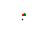

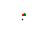

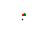

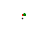

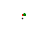

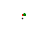

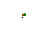

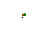

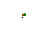

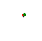

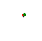

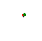

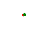

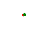

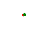

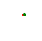

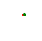

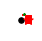

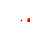

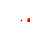

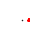

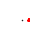

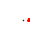

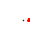

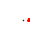

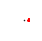

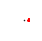

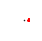

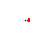

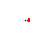

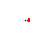

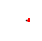

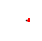

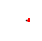

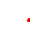

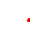

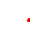

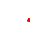

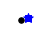

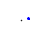

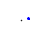

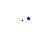

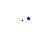

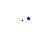

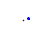

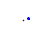

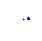

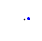

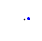

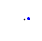

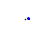

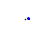

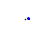

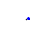

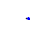

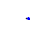

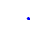

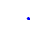

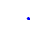

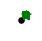

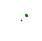

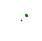

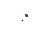

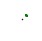

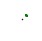

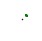

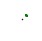

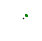

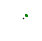

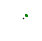

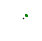

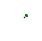

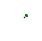

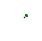

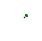

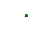

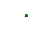

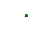

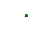

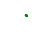

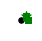

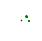

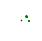

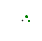

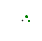

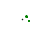

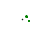

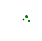

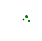

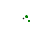

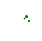

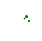

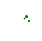

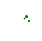

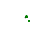

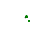

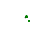

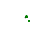

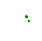

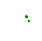

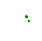

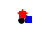

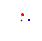

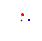

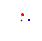

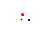

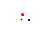

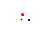

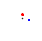

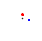

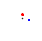

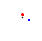

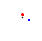

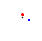

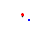

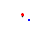

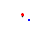

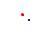

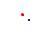

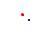

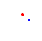

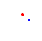

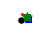

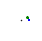

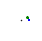

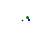

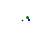

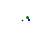

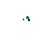

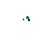

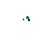

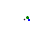

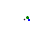

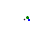

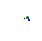

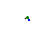

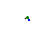

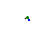

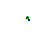

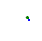

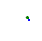

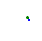

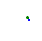

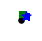

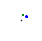

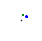

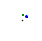

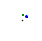

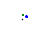

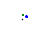

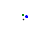

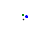

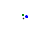

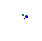

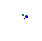

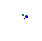

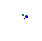

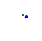

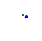

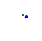

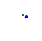

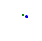

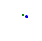

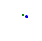

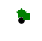

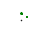

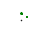

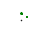

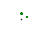

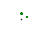

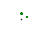

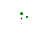

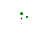

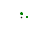

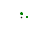

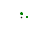

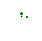

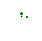

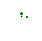

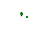

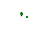

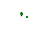

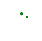

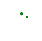

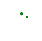

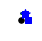

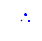

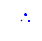

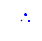

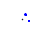

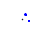

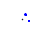

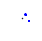

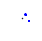

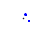

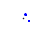

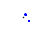

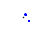

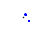

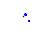

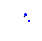

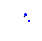

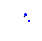

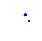

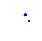

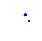

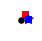

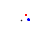

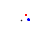

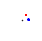

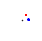

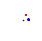

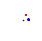

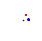

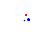

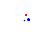

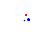

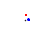

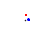

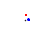

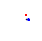

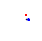

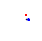

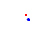

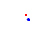

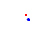

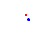

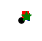

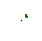

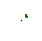

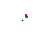

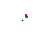

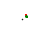

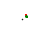

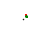

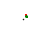

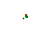

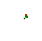

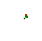

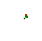

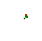

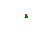

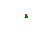

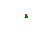

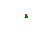

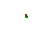

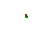

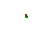

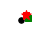

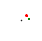

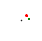

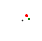

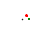

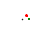

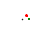

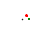

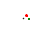

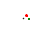

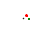

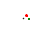

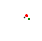

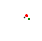

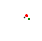

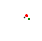

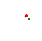

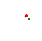

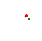

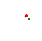

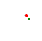

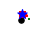

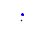

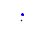

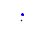

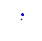

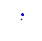

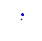

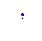

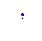

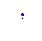

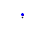

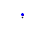

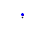

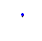

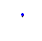

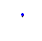

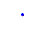

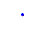

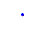

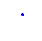

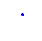

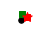

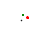

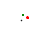

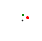

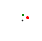

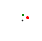

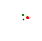

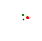

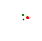

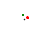

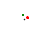

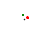

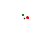

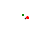

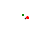

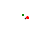

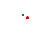

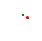

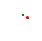

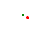

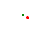

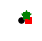

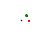

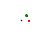

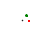

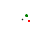

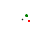

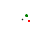

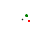

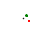

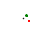

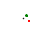

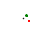

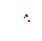

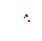

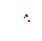

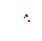

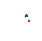

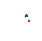

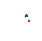

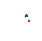

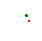

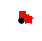

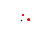

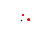

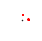

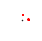

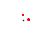

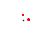

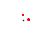

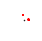

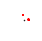

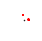

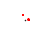

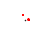

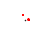

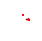

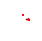

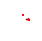

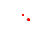

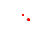

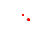

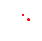

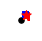

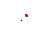

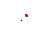

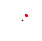

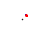

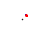

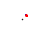

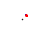

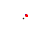

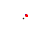

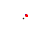

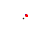

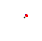

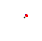

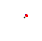

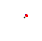

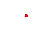

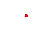

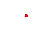

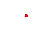

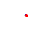

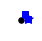

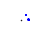

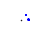

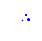

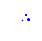

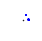

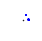

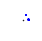

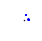

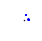

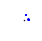

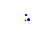

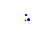

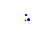

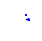

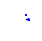

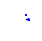

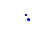

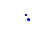

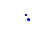

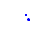

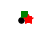

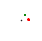

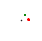

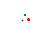

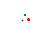

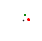

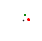

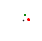

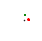

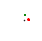

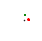

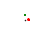

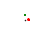

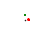

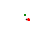

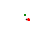

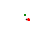

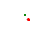

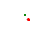

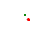

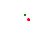

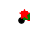

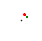

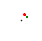

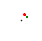

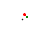

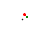

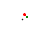

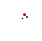

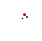

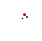

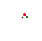

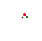

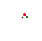

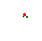

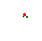

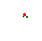

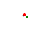

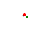

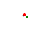

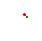

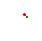

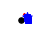

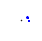

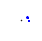

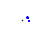

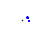

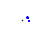

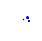

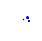

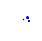

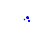

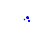

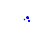

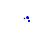

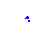

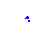

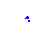

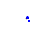

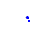

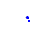

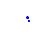

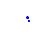

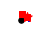

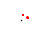

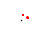

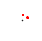

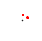

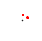

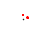

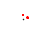

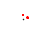

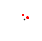

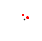

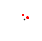

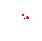

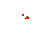

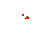

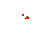

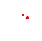

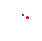

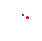

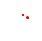

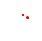

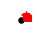

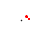

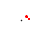

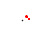

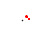

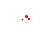

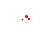

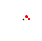

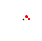

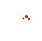

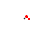

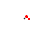

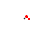

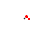

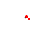

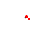

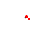

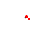

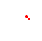

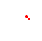

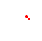

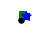

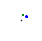

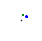

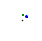

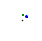

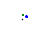

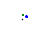

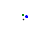

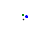

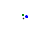

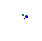

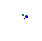

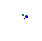

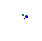

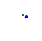

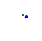

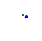

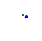

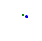

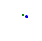

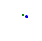

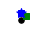

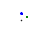

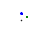

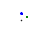

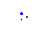

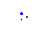

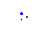

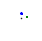

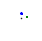

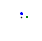

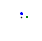

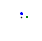

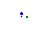

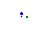

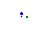

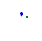

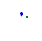

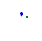

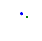

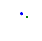

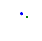

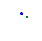

In [24]:
env = PointEnvComplex()
trajs = gen_trajs(env, num_trajs=100, obj_angles=90, obj_colors=[0,1,2], discretize=10)

[0. 1. 0.]


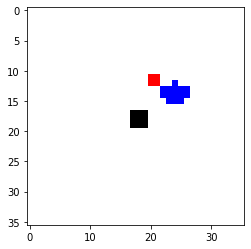

In [25]:
state = trajs[0]['obs'][0]
print(trajs[0]['goal'][0])
plt.imshow(state)

In [26]:
num_tasks = len(trajs)
horizon = 20

goal_size = 3
env = PointEnvComplex()
act_size = env.action_space.shape[0]
hidden_size = 100

policy = CNNPolicy(goal_size, act_size, hidden_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy.to(device)

CNNPolicy(
  (goal): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
  )
  (state): Sequential(
    (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Flatten()
    (7): Linear(in_features=32, out_features=100, bias=True)
    (8): ReLU(inplace=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)

[1,     1] loss: 1.01591861
[2,     1] loss: 0.71672261
[3,     1] loss: 0.14079231
[4,     1] loss: 0.14021385
[5,     1] loss: 0.12732208
[6,     1] loss: 0.11343912
[7,     1] loss: 0.08240703
[8,     1] loss: 0.08147410
[9,     1] loss: 0.06860191
[10,     1] loss: 0.06040265
[11,     1] loss: 0.07678841
[12,     1] loss: 0.05840566
[13,     1] loss: 0.05035960
[14,     1] loss: 0.04327214
[15,     1] loss: 0.03989856
[16,     1] loss: 0.03649734
[17,     1] loss: 0.03360674
[18,     1] loss: 0.03049031
[19,     1] loss: 0.02176507
[20,     1] loss: 0.03243083
[21,     1] loss: 0.02714161
[22,     1] loss: 0.02153012
[23,     1] loss: 0.03063980
[24,     1] loss: 0.03761861
[25,     1] loss: 0.02740150
[26,     1] loss: 0.02958087
[27,     1] loss: 0.02428180
[28,     1] loss: 0.02098892
[29,     1] loss: 0.02418322
[30,     1] loss: 0.02190110
[31,     1] loss: 0.02596191
[32,     1] loss: 0.01908985
[33,     1] loss: 0.01616327
[34,     1] loss: 0.01989822
[35,     1] loss: 0.018

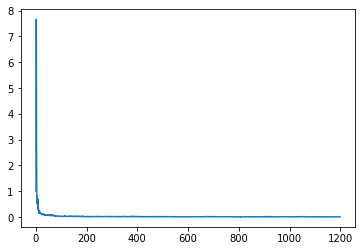

In [27]:
num_epochs = 200
batch_size = 20

criterion = nn.MSELoss()
optimizer = optim.Adam(list(policy.parameters()))

losses = []

idxs = np.array(range(len(trajs)))

num_batches = len(idxs) // batch_size
# Train the model with regular SGD
for epoch in range(num_epochs):  # loop over the dataset multiple times
    np.random.shuffle(idxs)
    running_loss = 0.0
    for i in range(num_batches):
        optimizer.zero_grad()

        t1_idx = np.random.randint(len(trajs), size=(batch_size,)) # Indices of traj
        t1_idx_pertraj = np.random.randint(20, size=(batch_size,)) # Indices of timesteps in traj
        t1_states = np.concatenate([trajs[c_idx]['obs'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_goals = np.concatenate([trajs[c_idx]['goal'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
        t1_actions = np.concatenate([trajs[c_idx]['acts'][t_idx][None] for (c_idx, t_idx) in zip(t1_idx, t1_idx_pertraj)])
   
        t1_states = torch.Tensor(t1_states).float().to(device)
        t1_goals = torch.Tensor(t1_goals).float().to(device)
        t1_actions = torch.Tensor(t1_actions).float().to(device)
        
        a1_pred = policy(t1_goals.to(device), t1_states.to(device)) # action prediction
        
        #mask_loss = 0.005*policy.mask_loss(t1_states.to(device)) # auxiliary mask loss (maybe need multiplier)
        loss = torch.mean(torch.linalg.norm(a1_pred - t1_actions, dim=-1)) # supervised learning loss
        #loss = mask_loss + supervised_loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss))
            #print('[%d, %5d] mask loss: %.8f' %
                  #(epoch + 1, i + 1, mask_loss))
            #print('[%d, %5d] action loss: %.8f' %
                  #(epoch + 1, i + 1, supervised_loss))
            losses.append(running_loss)
            running_loss = 0.0
        losses.append(loss.item())

print('Finished Training')
plt.plot(losses)

Final dist to goal:  -9.781831407164086
Final dist to goal:  -0.2960227438277798
Final dist to goal:  -0.1265832729985256
Final dist to goal:  -3.895691922042794
Final dist to goal:  -9.44985445855864
Final dist to goal:  -8.990073071776711
Final dist to goal:  -10.179835706838912
Final dist to goal:  -0.07394703167150393
Final dist to goal:  -6.867058792738968
Final dist to goal:  -9.907980803571762
Final dist to goal:  -9.338903957306828
Final dist to goal:  -9.442343453013688
Final dist to goal:  -4.790992249304023
Final dist to goal:  -8.70291136728196
Final dist to goal:  -9.535572319104702
Final dist to goal:  -9.971463649085987
Final dist to goal:  -0.06399624592125645
Final dist to goal:  -6.361833132027657
Final dist to goal:  -6.802371685845954
Final dist to goal:  -9.252240616022652
Average dist to goal:  -6.69157539430522
Average std:  3.6897062572311206


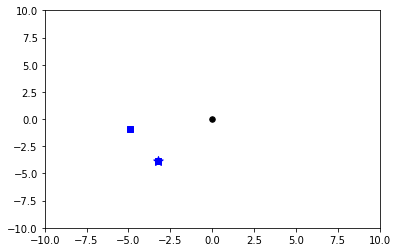

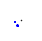

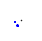

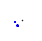

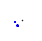

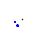

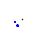

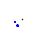

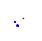

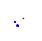

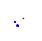

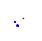

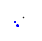

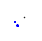

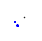

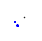

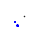

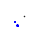

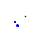

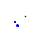

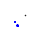

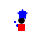

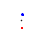

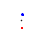

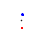

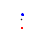

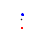

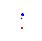

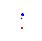

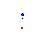

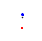

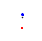

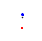

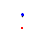

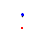

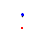

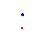

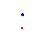

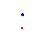

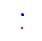

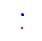

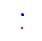

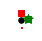

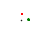

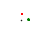

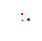

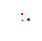

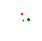

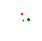

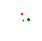

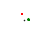

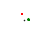

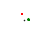

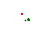

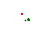

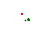

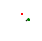

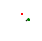

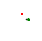

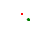

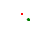

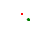

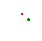

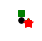

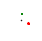

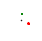

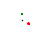

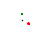

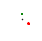

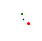

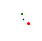

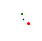

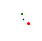

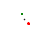

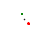

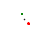

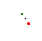

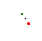

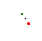

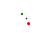

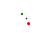

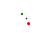

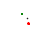

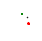

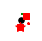

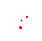

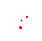

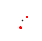

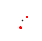

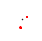

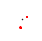

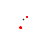

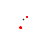

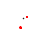

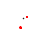

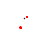

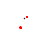

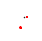

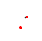

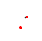

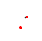

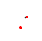

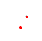

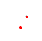

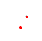

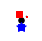

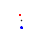

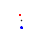

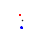

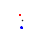

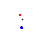

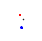

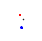

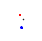

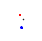

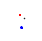

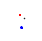

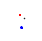

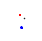

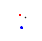

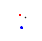

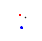

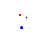

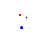

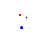

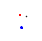

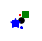

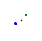

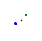

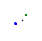

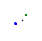

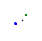

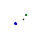

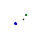

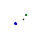

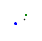

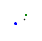

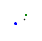

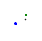

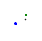

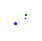

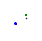

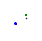

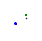

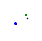

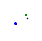

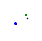

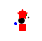

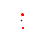

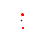

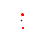

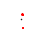

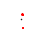

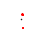

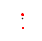

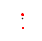

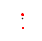

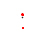

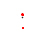

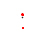

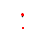

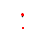

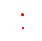

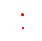

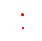

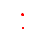

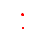

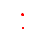

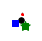

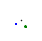

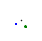

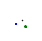

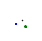

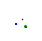

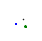

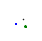

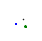

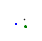

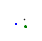

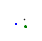

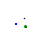

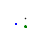

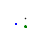

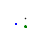

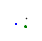

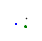

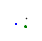

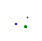

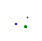

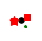

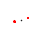

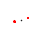

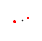

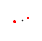

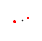

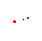

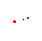

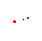

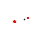

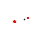

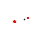

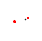

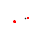

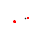

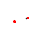

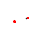

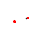

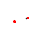

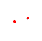

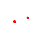

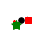

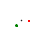

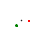

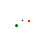

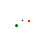

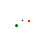

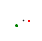

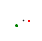

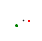

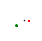

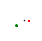

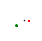

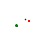

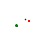

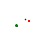

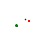

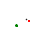

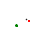

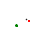

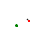

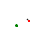

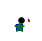

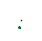

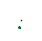

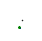

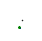

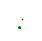

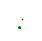

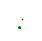

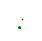

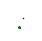

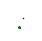

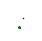

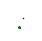

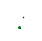

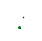

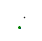

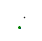

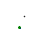

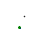

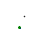

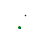

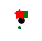

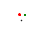

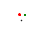

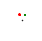

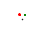

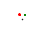

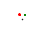

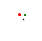

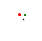

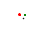

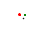

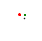

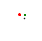

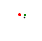

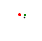

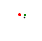

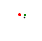

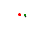

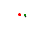

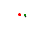

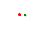

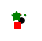

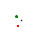

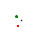

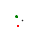

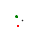

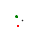

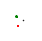

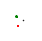

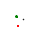

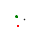

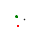

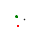

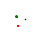

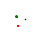

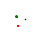

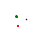

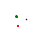

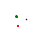

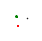

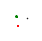

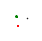

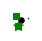

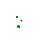

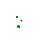

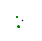

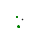

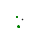

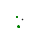

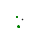

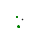

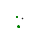

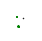

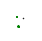

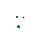

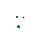

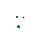

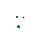

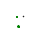

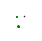

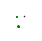

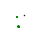

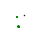

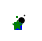

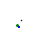

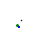

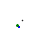

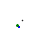

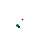

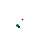

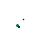

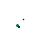

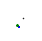

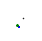

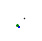

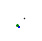

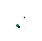

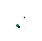

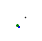

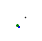

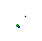

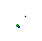

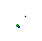

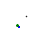

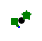

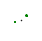

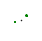

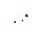

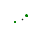

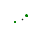

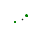

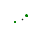

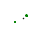

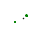

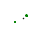

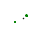

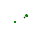

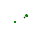

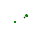

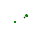

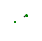

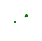

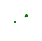

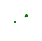

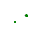

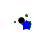

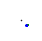

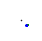

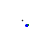

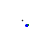

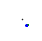

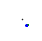

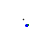

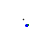

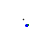

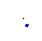

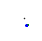

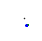

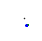

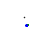

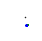

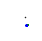

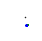

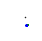

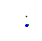

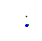

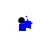

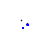

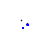

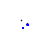

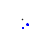

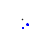

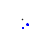

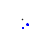

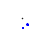

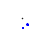

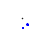

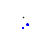

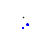

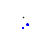

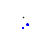

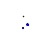

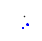

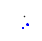

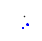

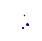

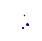

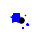

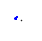

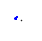

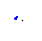

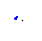

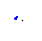

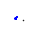

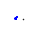

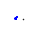

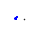

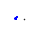

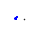

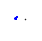

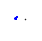

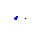

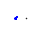

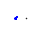

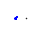

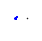

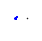

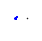

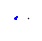

In [28]:
plt.xlim(-10, 10)
plt.ylim(-10, 10)
colors = sns.color_palette("hls", 10)

num_test_trajs = 20
# sets sampling for angles and colors
test_obj_angles = 360
test_obj_colors = [0,1,2]
discretize = 10

dist_to_goals = []

for i in range(num_test_trajs):
    env.reset(test_obj_angles, test_obj_colors, discretize)
    plot_env(env)
    goal = torch.Tensor(env.goal_color[None]).to(device)
    o = plot_full_state(env.get_full_obs())
    #print("Goal location: ", env.goal_pos)
    #print("Goal color: ", get_color(env.goal_color))
    
    traj = {'obs': [],'acts': [], 'true_goal': []}
    for i in range(20):
        state = torch.Tensor(o[None]).to(device)
        action = policy(goal,state).cpu().detach().numpy()[0]
        no, r, d, _ = env.step(action)
        traj['obs'].append(o.copy())
        traj['acts'].append(action.copy())
        traj['true_goal'].append(env.goal_color)
        o = plot_full_state(no.copy())
    traj['obs'] = np.array(traj['obs'])
    traj['acts'] = np.array(traj['acts'])
    traj['true_goal'] = np.array(traj['true_goal'])
    dist_to_goals.append(r.copy())
    print("Final dist to goal: ", r)
    #plt.plot(traj['obs'][:, 0], traj['obs'][:, 1]) # plots trajs
print("Average dist to goal: ", np.mean(dist_to_goals))
print("Average std: ", np.std(dist_to_goals))